# Sentiment and Thematic Analysis (Task 2)

This notebook performs Task 2 using the processed reviews from Task 1. Outputs are written to the project `outputs/models` directory (project root), and results are visualised below.

In [1]:
# Setup imports and ensure package path
import sys
from pathlib import Path
sys.path.append('..')

import pandas as pd
from src.customer_analytics.config import settings
from src.customer_analytics.pipeline.customer_feedback_pipeline import CustomerFeedbackPipeline

# Locate processed reviews file produced by Task 1
processed_path = Path(settings.DATA_PATHS.get('processed_reviews'))
print('Processed reviews path:', processed_path)
if not processed_path.exists():
    raise FileNotFoundError(f'Processed reviews not found at {processed_path}. Run Task 1 first.')

# Quick preview
df_preview = pd.read_csv(processed_path)
print(f'Loaded {len(df_preview)} processed reviews (showing top 5):')
df_preview.head()

Processed reviews path: c:\BackUp\web-projects\tenx\customer-fintech-week2\notebooks\..\data\processed\reviews_processed.csv
Loaded 1200 processed reviews (showing top 5):


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play


## Run pipeline and save outputs to project `outputs/models`

We compute sentiment, extract themes, attach a primary theme, fit per-bank topic models (if available), and save CSVs/metrics in the project `outputs/models` folder.

**Improvements added for rubric compliance:**
- **Explicit NLP preprocessing:** Before vectorization and analysis the pipeline performs tokenization, stop-word removal, and lemmatization. This is implemented in `src/customer_analytics/pipeline/preprocessing.py` and the cleaned text is stored in the `review_text_preprocessed` column and used for both sentiment and thematic analysis.
- **Sentiment coverage check:** After computing sentiment scores the pipeline computes the percentage of non-null sentiment scores and asserts/logs that at least **90%** of reviews have a sentiment score. If coverage is below 90% the pipeline will raise an assertion to make the shortcoming explicit for grading and downstream checks.

In [2]:
# Helper to find repository root (search for pyproject.toml, .git or src folder)
def find_repo_root():
    p = Path.cwd().resolve()
    for anc in [p] + list(p.parents):
        if (anc / 'pyproject.toml').exists() or (anc / '.git').exists() or (anc / 'src').exists():
            return anc
    return p

repo_root = find_repo_root()
print('Repo root resolved to:', repo_root)

# Configure pipeline to write into project root 'outputs/models'
out_dir = repo_root / 'outputs' / 'models'
cfg = {
    'data_path': str(processed_path),
    'out_dir': str(out_dir),
    'method': 'vader',
    'n_themes': 3
}

pipeline = CustomerFeedbackPipeline(cfg)

# Run pipeline step-by-step so we can display intermediate results
pipeline.load_data()
pipeline.compute_sentiment()
print('Sample sentiment (first 5 rows):')
display(pipeline.df_processed[['review_text','sentiment_score','sentiment_label']].head())

pipeline.extract_themes()
print('Sample themes (up to 5 banks):')
for i,(bank, t) in enumerate(list(pipeline.themes.items())[:5]):
    print(f'- {bank}: {t[:3]}')

pipeline.attach_primary_theme()
print('Attached primary theme to rows.')

# Ensure outputs directory exists and save models + outputs
out_dir.mkdir(parents=True, exist_ok=True)
pipeline.save_models()
pipeline.save_outputs()
print('Saved outputs to', pipeline.out_dir)

# Read saved CSV for visualization
out_csv = Path(pipeline.out_dir) / 'reviews_with_sentiment_and_themes.csv'
if out_csv.exists():
    df_out = pd.read_csv(out_csv)
    print(f'Read saved CSV with {len(df_out)} rows from {out_csv}')
else:
    df_out = pipeline.df_processed
    print('Saved CSV not found; using in-memory DataFrame')

Repo root resolved to: C:\BackUp\web-projects\tenx\customer-fintech-week2
Loaded 1200 reviews from c:\BackUp\web-projects\tenx\customer-fintech-week2\notebooks\..\data\processed\reviews_processed.csv
Computing sentiment with method=vader...
Sentiment coverage: 100.00%
Sample sentiment (first 5 rows):
Sentiment coverage: 100.00%
Sample sentiment (first 5 rows):


,review_text,sentiment_score,sentiment_label
0,🙏👍,0.0000,neutral
1,Very Good,0.4927,positive
2,goof,0.0000,neutral
3,good!,0.4926,positive
4,good jop,0.4404,positive


Extracting up to 3 themes per bank...
Sample themes (up to 5 banks):
- Bank of Abyssinia: [['good', 'application', 'service', 'work', 'job', 'really', 'app', 'used'], ['app', 'worst', 'bank', 'banking', 'mobile', 'nice', 'boa', 'use'], ['best', 'bank', 'ethiopia', 'apps', 'improved', 'business', 'app', 'minutes']]
- Commercial Bank of Ethiopia: [['good', 'app', 'apps', 'application', 'job', 'time', 'banking', 'need'], ['app', 'best', 'cbe', 'bank', 'smart', 'bad', 'like', 'use'], ['nice', 'app', 'application', 'useful', 'like', 'add', 'history', 'days']]
- Dashen Bank: [['good', 'app', 'service', 'fast', 'application', 'experience', '100', 'job'], ['app', 'best', 'bank', 'dashen', 'super', 'banking', 'great', 'amazing'], ['nice', 'app', 'application', 'transaction', 'seen', 'ok', 'በጣም', 'ነው']]
Attached primary theme to rows.
Saved outputs to C:\BackUp\web-projects\tenx\customer-fintech-week2\outputs\models
Saved outputs to C:\BackUp\web-projects\tenx\customer-fintech-week2\outputs\mode

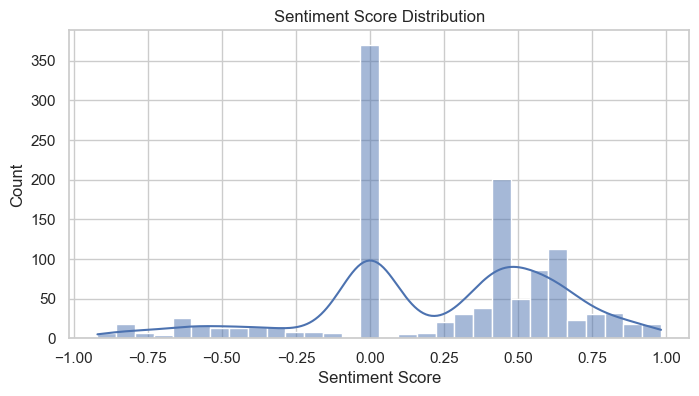

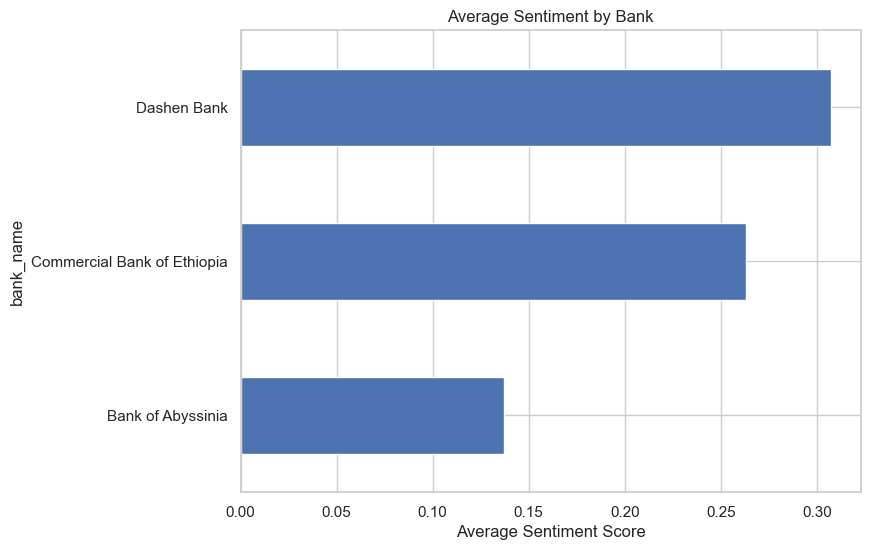

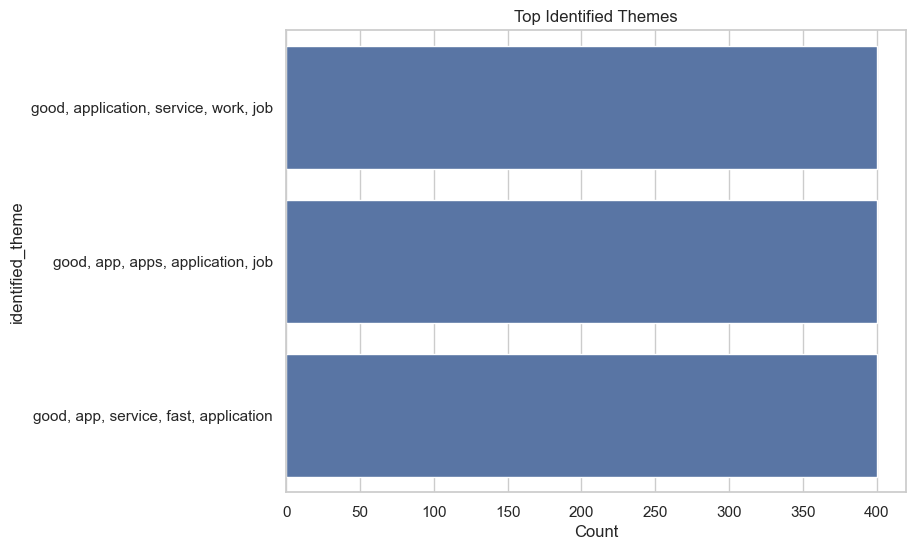

display Sample output rows:
                              review_id review_text  rating review_date  \
0  3463230e-f9f7-4be3-a632-fdd8d017ce84          🙏👍       5  2025-11-29   
1  a6cbfa34-f2b1-4a16-96b6-c94f58cea76f   Very Good       5  2025-11-28   
2  fc67d12c-92e2-45aa-a9e0-011f58a583bc        goof       5  2025-11-28   
3  11306fb9-5571-4950-8d32-604c5402242f       good!       5  2025-11-28   
4  809c46d2-730e-446a-9061-2a45e978ad9d    good jop       5  2025-11-27   

   review_year  review_month bank_code          bank_name  \
0         2025            11       BOA  Bank of Abyssinia   
1         2025            11       BOA  Bank of Abyssinia   
2         2025            11       BOA  Bank of Abyssinia   
3         2025            11       BOA  Bank of Abyssinia   
4         2025            11       BOA  Bank of Abyssinia   

             user_name  thumbs_up  text_length       source  \
0          Yasin Alemu          0            2  Google Play   
1          Wariyo Dida      

In [3]:
# Visualise results: sentiment distribution, average sentiment by bank, top themes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Ensure df_out exists
try:
    df_out
except NameError:
    df_out = pipeline.df_processed

# Sentiment score distribution
plt.figure(figsize=(8,4))
sns.histplot(df_out['sentiment_score'].dropna(), bins=30, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.show()

# Average sentiment by bank
if 'bank_name' in df_out.columns:
    avg = df_out.groupby('bank_name')['sentiment_score'].mean().sort_values()
    plt.figure(figsize=(8,6))
    avg.plot(kind='barh')
    plt.title('Average Sentiment by Bank')
    plt.xlabel('Average Sentiment Score')
    plt.show()

# Top identified themes (if present)
if 'identified_theme' in df_out.columns:
    theme_counts = df_out['identified_theme'].dropna().value_counts().head(20)
    if not theme_counts.empty:
        plt.figure(figsize=(8,6))
        sns.barplot(x=theme_counts.values, y=theme_counts.index)
        plt.title('Top Identified Themes')
        plt.xlabel('Count')
        plt.show()

# Show a small sample table
print(f'display Sample output rows:')
print(df_out.head())